In [ ]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy import stats as st
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

def warn(*args, **kwargs):
    pass
warnings.warn = warn

Читаем данные

In [ ]:
df = pd.read_excel("/content/07-04-2023_v4.xlsx")
df.head(5)

,Unnamed: 0,title,cars,metro,dist,address,price,price_info,description,url,...,rooms,meters,apt_floot,max_floor,PPM,okrug,district,util_price,TPrice24M,TPrice24MPM
0,0,Люкс! Можно с животными!Свободна!,"1-комн. кв., 20 м², 8/16 этаж",Селигерская,15.0,Москва; САО; р-н Дмитровский; м. Селигерская; ...,28000,"От года, комм. платежи включены (без счётчиков...",-МОЖНО С ПИТОМЦАМИ !\n- Оперативный показ. СВО...,https://www.cian.ru/rent/flat/284224687/,...,1.0,20.0,8.0,16.0,1400.000000,САО,Дмитровский,2000.0,778000.0,38900.000000
1,1,Топовый вариант! Животные-Да,"1-комн. кв., 20 м², 3/16 этаж",Селигерская,15.0,Москва; САО; р-н Дмитровский; м. Селигерская; ...,28000,"От года, комм. платежи включены (без счётчиков...",Возьмём с воспитанным ПИТОМЦЕМ! Для одного чел...,https://www.cian.ru/rent/flat/283607980/,...,1.0,20.0,3.0,16.0,1400.000000,САО,Дмитровский,2000.0,778000.0,38900.000000
2,2,Животные ДА!Эксклюзив!БЕЗ залога!,"2-комн. кв., 42 м², 5/5 этаж",Перово,10.0,Москва; ВАО; р-н Перово; м. Перово; 3-я Владим...,28000,"От года, комм. платежи включены (без счётчиков...","- Оперативный показ, ЗАСЕЛЕНИЕ В ДЕНЬ ПРОСМОТР...",https://www.cian.ru/rent/flat/285368200/,...,2.0,42.0,5.0,5.0,666.666667,ВАО,Перово,4200.0,791000.0,18833.333333
3,3,"Вариант БОМБА,МЕТРО ВЫХИНО,ДЁШЕВО","1-комн. кв., 35 м², 1/9 этаж",Выхино,10.0,Москва; ВАО; р-н Вешняки; м. Выхино; улица Мол...,27000,"От года, комм. платежи включены (без счётчиков...","МОСКВА,УЛИЦА МОЛДАГУЛОВОЙ,д.28,к.1,ВАО,РАЙОН ""...",https://www.cian.ru/rent/flat/256265698/,...,1.0,35.0,1.0,9.0,771.428571,ВАО,Вешняки,3500.0,775200.0,22148.571429
4,4,Уютное жилье по доступной цене!,"1-комн. кв., 27 м², 1/21 этаж",Остафьево,7.0,Москва; НАО (Новомосковский); м. Остафьево; Ще...,28499,"От года, комм. платежи включены (без счётчиков...",Ищете уютное жилье по доступной цене? У нас ес...,https://www.cian.ru/rent/flat/228514822/,...,1.0,27.0,1.0,21.0,1055.518519,НАО,Щербинка,2700.0,766776.0,28399.111111


## Шаг 3: Предварительныя обработка (максимум 10 баллов)

### 3.1. Проверка на явные дубликаты

In [ ]:
print(df.duplicated().sum())

0


### 3.2. Пропущенные значения

In [ ]:
pd.options.display.float_format = '{:,.2f}%'.format
print((df.isna().sum()/df.count()).sort_values(ascending=False))
pd.options.display.float_format = '{:.2f}'.format

cars          11.01%
apt_floot     11.01%
max_floor     11.01%
description    5.26%
user_url       0.40%
user_type      0.08%
rooms          0.04%
phone          0.03%
district       0.01%
okrug          0.01%
address        0.01%
dist           0.01%
metro          0.01%
user           0.00%
util_price     0.00%
TPrice24M      0.00%
PPM            0.00%
meters         0.00%
TPrice24MPM    0.00%
deposit        0.00%
commission     0.00%
utilities      0.00%
duration       0.00%
title          0.00%
date           0.00%
url            0.00%
price_info     0.00%
price          0.00%
Unnamed: 0     0.00%
dtype: float64


Пропущенные значения обнаружены в столбцах `cars`, `apt_floot`, `max_floor`, `description`.

* Решить проблему с `cars` не получится, т.к. это текстовое описание и является уникальным для каждой записи.

* Люди часто не указывают этаж квартиры, если это может плохо сказаться на стоимости квартиры, например, квартира находится на максимальном этаже. Заменим пропуски на значение максимального этажа в доме, это будет безопасной тактикой.

* Так же люди не указывают максимальный этаж, если он негативно сказывается на стоимости квартиры. Заменим на медиану по округу (`okrug`). Мы выбираем медаину, т.к. она является устойчивой к выбросам статистикой.

In [ ]:
column = 'max_floor'
for okrug_name in df['okrug'].unique():
  new_value = df[df['okrug'] == okrug_name][column].median()
  df.loc[df['okrug'] == okrug_name, column] = df.loc[df['okrug'] == okrug_name][column].fillna(new_value)

# Там где не получилось сделать замену -- удаляем
df = df.dropna(subset=['max_floor'])

In [ ]:
df['apt_floot'] = df['apt_floot'].fillna(df['max_floor'])

In [ ]:
df['rooms'] = df['rooms'].fillna(df['rooms'].median())

### 3.3. Обработка типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28125 entries, 0 to 28402
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   28125 non-null  int64  
 1   title        28125 non-null  object 
 2   cars         2365 non-null   object 
 3   metro        27969 non-null  object 
 4   dist         27969 non-null  float64
 5   address      28067 non-null  object 
 6   price        28125 non-null  int64  
 7   price_info   28125 non-null  object 
 8   description  4496 non-null   object 
 9   url          28125 non-null  object 
 10  date         28125 non-null  object 
 11  phone        27277 non-null  object 
 12  user_type    26157 non-null  object 
 13  user         28069 non-null  object 
 14  user_url     20063 non-null  object 
 15  duration     28125 non-null  object 
 16  utilities    28125 non-null  object 
 17  commission   28125 non-null  float64
 18  deposit      28125 non-null  int64  
 19  room

Переведём столбец `date` в тип данных `datetime`

In [ ]:
# Определим функцию для парсинга дат
month_mapping = {
    'янв': 'Jan',
    'фев': 'Feb',
    'мар': 'Mar',
    'апр': 'Apr',
    'май': 'May',
    'июн': 'Jun',
    'июл': 'Jul',
    'авг': 'Aug',
    'сен': 'Sep',
    'окт': 'Oct',
    'ноя': 'Nov',
    'дек': 'Dec'
}


def parse_custom_date(date_string):
  date_string = date_string.replace(',', '')
  day, month_abbr, time = date_string.split()

  # Заменяем русское название месяца на английское
  month = month_mapping[month_abbr]

  # Собираем вместе как строку
  date_string = f'{day} {month} {time}'

  return date_string

In [ ]:
df['date'] = df['date'].apply(parse_custom_date)
df['date'] = pd.to_datetime(df['date'], format='%d %b %H:%M')

# Выделим день, месяц и время
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['time'] = df['date'].dt.time

Переведём целочисленные по смыслу названия столбцы к типу данных `int`

In [ ]:
df['rooms'] = df['rooms'].astype(int)
df['apt_floot'] = df['apt_floot'].astype(int)
df['max_floor'] = df['max_floor'].astype(int)

## Шаг 4. Визуализация

### 4.1. Гистограммы цен, комнат, этажей и округов

Text(0.5, 0, 'Цена')

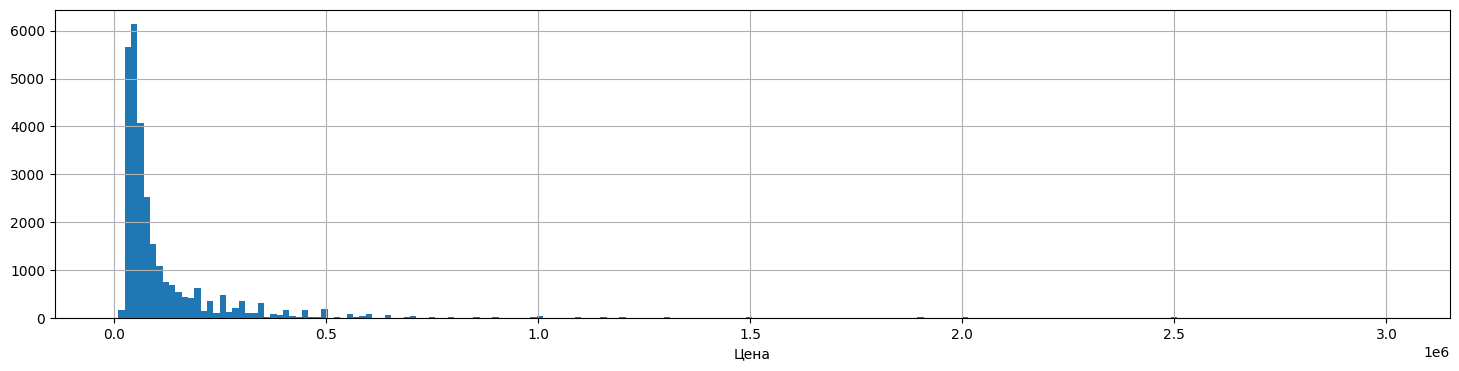

In [ ]:
plt.figure(figsize=(18, 4))
df['price'].hist(bins=200)
plt.xlabel('Цена')

Средняя цена в окрестности 100K.

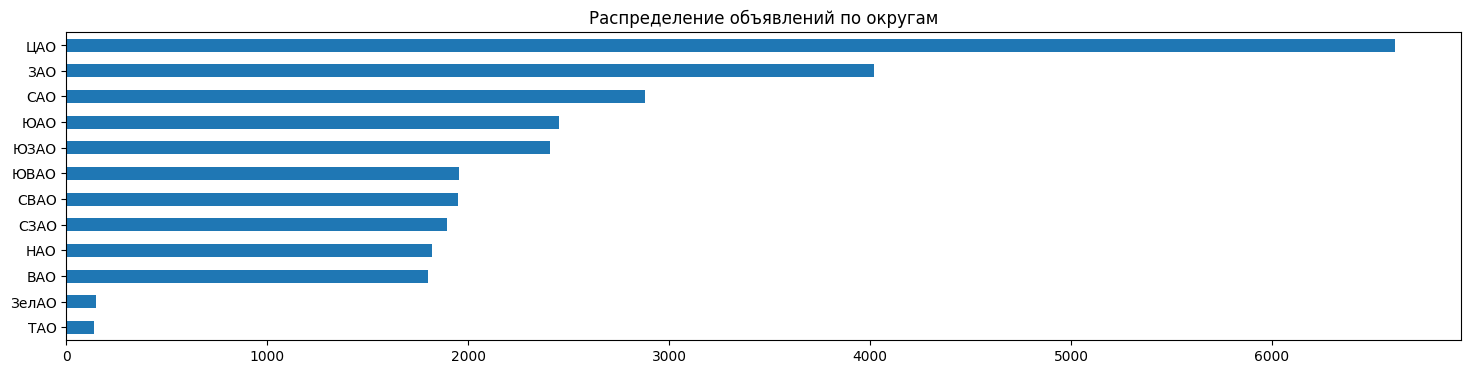

In [ ]:
plt.figure(figsize=(18, 4))
df['okrug'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('Распределение объявлений по округам');

Большинство квартир расположены в ЦАО, далее следуют ЗАО и САО. Менее распространенным округом является ТАО (Троицкий административный округ).

<Axes: title={'center': 'Кол-во комнат'}>

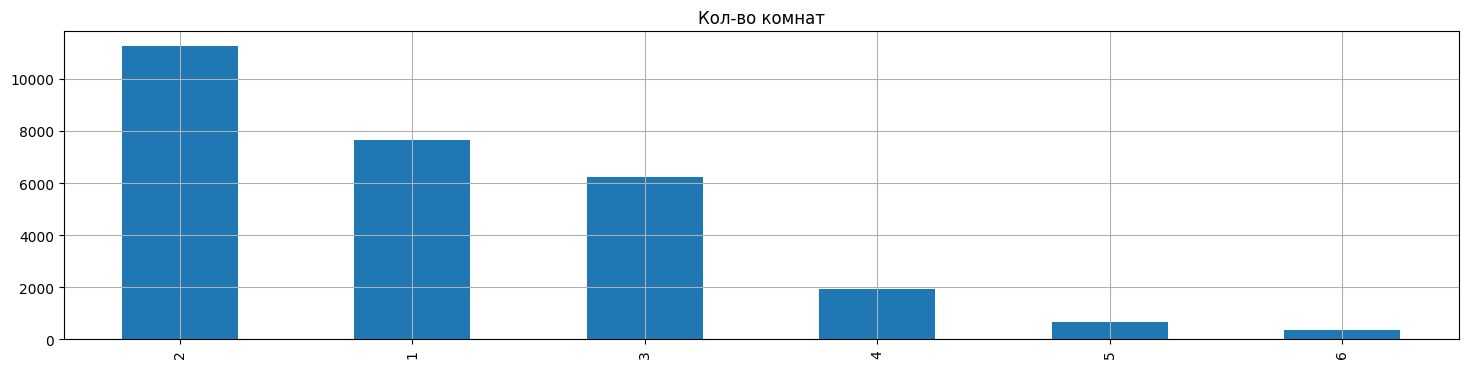

In [ ]:
df['rooms'].value_counts().plot.bar(figsize=(18, 4), title='Кол-во комнат', grid=True)

Большинство квартир имеют 2 комнаты.

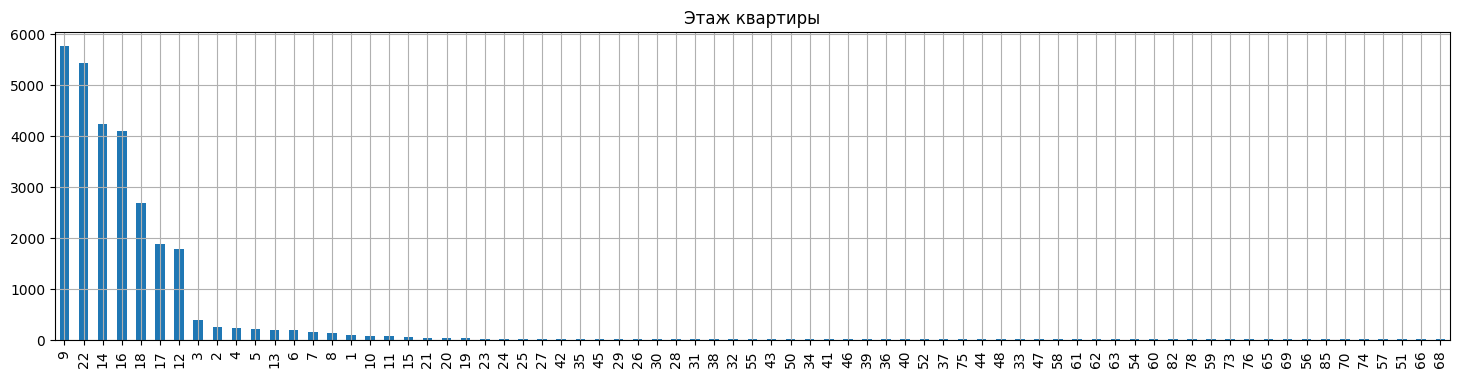

In [ ]:
df['apt_floot'].value_counts().plot.bar(grid=True, figsize=(18, 4), title='Этаж квартиры');

Большинство квартир из полученных данных располагаются на 9-ом этаже, далее следует 22-ой.

## 4.3. Точечные графики зависимости переменных

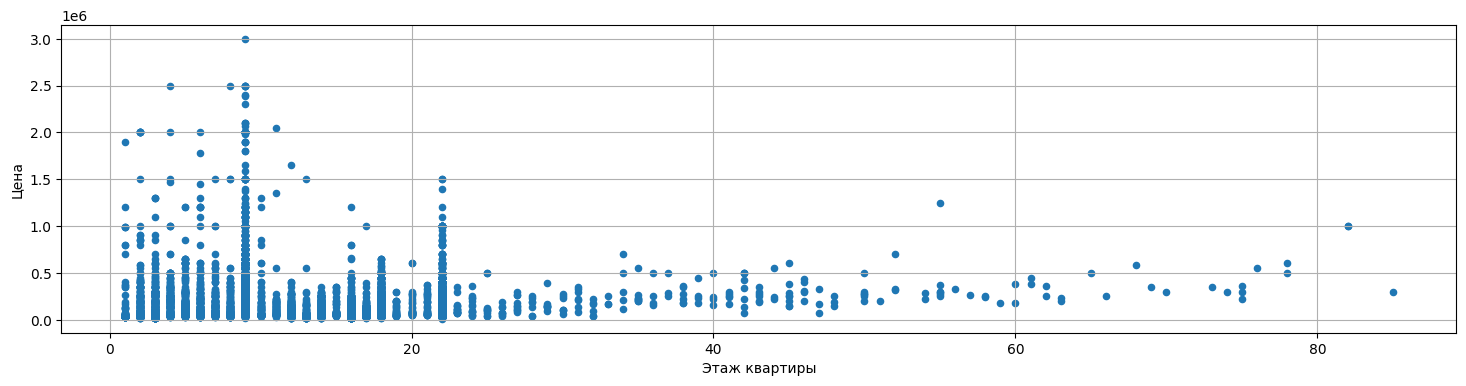

In [ ]:
df.plot(kind='scatter', x='apt_floot', y='price', grid=True, figsize=(18, 4))
plt.xlabel('Этаж квартиры')
plt.ylabel('Цена');

Наиболее дорогие квартиры находится ниже 10-го этажа.

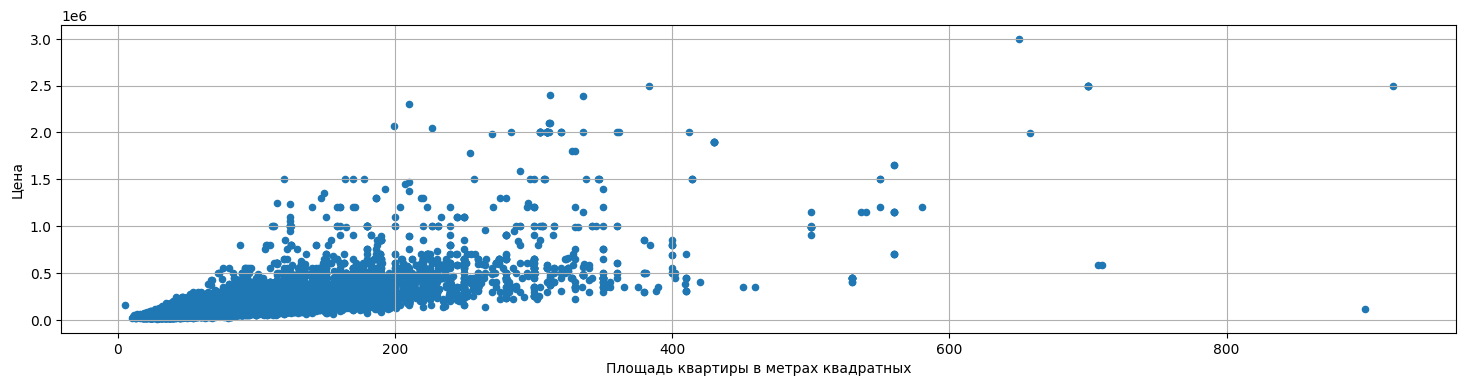

In [ ]:
df.plot(kind='scatter', x='meters', y='price', grid=True, figsize=(18, 4))
plt.xlabel('Площадь квартиры в метрах квадратных')
plt.ylabel('Цена');

Наблюдается линейная зависимость между площадью квартиры и ценой квартиры.

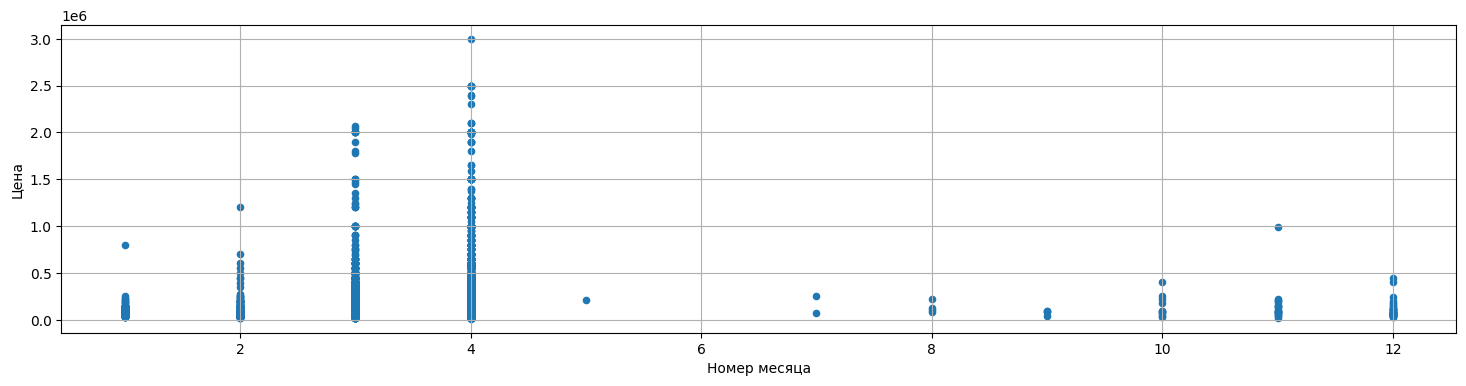

In [ ]:
df.plot(kind='scatter', x='month', y='price', grid=True, figsize=(18, 4))
plt.xlabel('Номер месяца')
plt.ylabel('Цена');

Большинство объявлений приходится на весну, кроме того, в данный сезон замечены наибольшие цены. Однако это можно объяснить тем, что данные были собраны в апреле.

## 4.4. Визуализация текстовых данных

In [ ]:
def create_wordcloud_from_column(df, column_name, title, max_token_len=3):
    preprocessed_tokens = []
    for tokens in df[column_name].str.split().tolist():
        try:
          for token in tokens:
            if len(token) > max_token_len:
              preprocessed_tokens.append(token.lower().strip().strip('-').strip('.'))
        except:
          pass

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(' '.join(preprocessed_tokens))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()


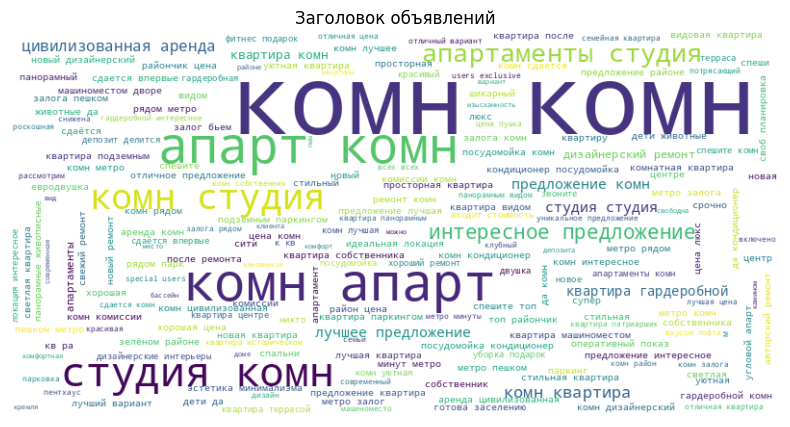

In [ ]:
create_wordcloud_from_column(df, 'title', 'Заголовок объявлений', max_token_len=4)

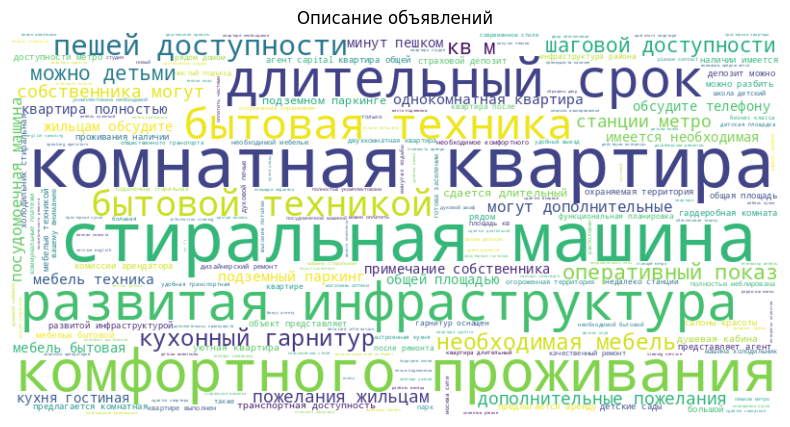

In [ ]:
create_wordcloud_from_column(df, 'description', 'Описание объявлений', max_token_len=4)

Наиболее распространенными словами в описании объявления являются `длительнный`, `инфраструктура`, `комфортный`, а так же слова, описывающие элементы кухни и жилого пространства.

Можно сделать вывод, что большинство квартир сдаются на длительный срок с кухонным оборудованием и мебелью.

# Шаг 5. Создание новых признаков

Признак "Конец квартала"

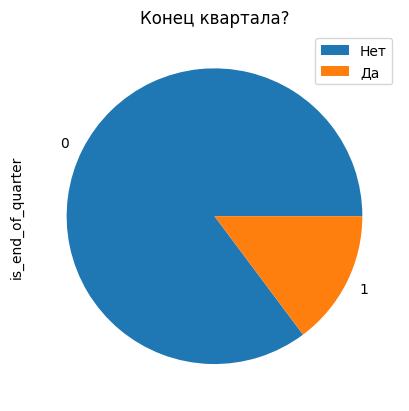

In [ ]:
df['is_end_of_quarter'] = df['month'].apply(lambda x: x % 3 == 0)
df['is_end_of_quarter'].astype(int).value_counts().plot(kind='pie', title='Конец квартала?')
plt.legend(['Нет', 'Да'])

Признак "Больше года"

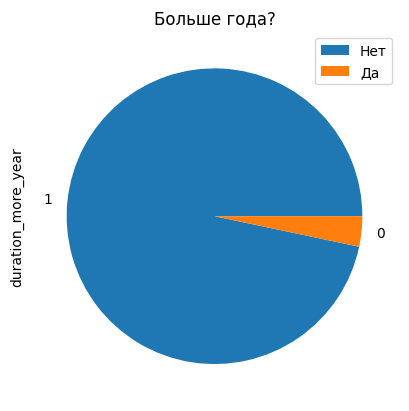

In [ ]:
df['duration_more_year'] = df['duration'].apply(lambda x: x == 'От года')
df['duration_more_year'].astype(int).value_counts().plot(kind='pie', title='Больше года?')
plt.legend(['Нет', 'Да'])

Признак (внутри МКАД)

Три округа Москва расположены вне МКАД:

**Зеленоградский округ** (ЗелАО) - расположен на северо-западе Москвы, за МКАД.

**Новомосковский округ** (НАО)- занимает юго-западную часть Москвы, за пределами МКАД, включая территорию бывших Московских округов Троицк и Новомосковск.

**Троицкий округ** (ТАО) - находится к юго-западу от МКАД, в составе Новомосковского округа.


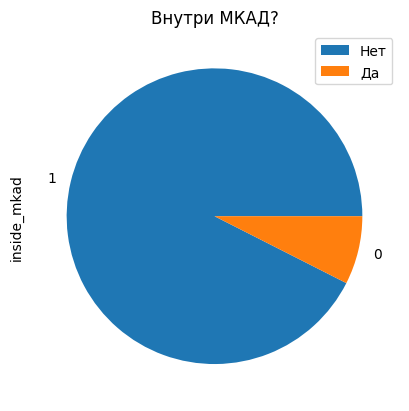

In [ ]:
okrugs_outside_mkad = {'ЗелАО', 'ТАО', 'НАО'}
df['inside_mkad'] = df['okrug'].apply(lambda x: x not in okrugs_outside_mkad)
df['inside_mkad'].astype(int).value_counts().plot(kind='pie', title='Внутри МКАД?')
plt.legend(['Нет', 'Да'])

Признак "Квартира находится на >10 этаже"

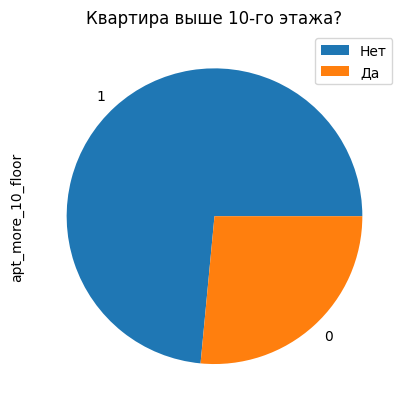

In [ ]:
df['apt_more_10_floor'] = df['apt_floot'].apply(lambda x: x > 10)
df['apt_more_10_floor'].astype(int).value_counts().plot(kind='pie', title='Квартира выше 10-го этажа?')
plt.legend(['Нет', 'Да'])

# Шаг 6. Гипотезы

## 6.1. Гипотеза "Средняя цена за МКАДом меньше, чем средняя цена внутри МКАДа"

Пусть $n_1, n_2$ - цены внутри МКАДа и за МКАДом, соответственно. Тогда сформулируем гипотезы:

$H_0 = \{n_1 = n_2\}$

$H_1 = \{n_1 \ne n_2\}$

Проверим данные гипотезы с помощью T-теста с уровнем значимости $\alpha = 0.05$

In [ ]:
prices_inside_mkad = df[df['inside_mkad'] == True]['price']
prices_outside_mkad = df[df['inside_mkad'] == False]['price']

In [ ]:
alpha = 0.05
results = st.ttest_ind(prices_inside_mkad, prices_outside_mkad)
print("p-значение: {:.3f}".format(results.pvalue))
print("Уровень значимости: {}".format(alpha))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")
    
print("Отношение цены внутри МКАДа к цене за МКАДом: {:.2f}".format(
    (prices_inside_mkad.mean() / prices_outside_mkad.mean())
    )
)

p-значение: 0.000
Уровень значимости: 0.05
Отвергаем нулевую гипотезу
Отношение цены внутри МКАДа к цене за МКАДом: 2.97


Таким образом, цена внутри МКАДа больше в три раза.

## 6.2. Гипотеза "Средняя цена квартиры ниже 10-го этаже не равна средней цене квартиры выше 10-го этажа"

Пусть $n_1, n_2$ - цены ниже 10-го этажа и выше 10-го этажа, соответственно, тогда

$H_0 = \{n_1 = n_2\}$

$H_1 = \{n_1 \ne n_2\}$

Проверим данные гипотезы с помощью T-теста с уровнем значимости $\alpha = 0.05$

In [ ]:
prices_apt_more_10_floor = df[df['apt_more_10_floor'] == True]['price']
prices_apt_less_10_floor = df[df['apt_more_10_floor'] == False]['price']

In [ ]:
alpha = 0.05
results = st.ttest_ind(prices_apt_more_10_floor, prices_apt_less_10_floor)
print("p-значение: {:.3f}".format(results.pvalue))
print("Уровень значимости: {}".format(alpha))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")
    
print("Отношение цены ниже 10-го этажа к цене выше 10-го этажа: {:.2f}".format(
    (prices_apt_less_10_floor.mean() / prices_apt_more_10_floor.mean())
    )
)

p-значение: 0.000
Уровень значимости: 0.05
Отвергаем нулевую гипотезу
Отношение цены ниже 10-го этажа к цене выше 10-го этажа: 2.90


Таким образом, цена на квартиру ниже 10-го этажа почти в три раза больше, чем цена на квартиру выше 10-го этажа.

## 6.3. Гипотеза "Существует линейная связь между площадью квартиры и её ценой"

Проверим, что получится построить линейную модель, описывающую зависимость между площадью квартиры и её ценой.

In [ ]:
df = df.dropna(subset=['meters', 'price'])

# Определяем зависимые и независимые переменные
x = df['meters']
y = df['price']

# Добавим константу к независимой переменной
X = sm.add_constant(x)

# Создаем модель
model = sm.OLS(y, X)
results = model.fit()

# Выводим на экран результаты модели
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                 4.019e+04
Date:                Fri, 09 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:30:44   Log-Likelihood:            -3.6390e+05
No. Observations:               28121   AIC:                         7.278e+05
Df Residuals:                   28119   BIC:                         7.278e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.851e+04    996.764    -48.665      0.0

Как можно видеть, мы получили достаточно качественную линейную модель, что потверждает гипотезу о линейной зависимости.

## Шаг 7. Машинное обучение 

Будем решать задачу регресии относительно переменной `price`, т.е. мы будем пресказывать цену аренды квартиры по её признакам. В качестве метрик будем использовать $MSE$ и $R^2$.

Решение данной задачи может быть полезным для системы рекомендации цены на сайте объявлений.

In [ ]:
# Словари для хранения моделей и соответствующих метрик
MODELS = {}
METRICS = {}

### 7.1. Подготовка датасета

Удалим бесполезные переменные и переменные, которые создают data leak (например, `TPrice24M`, `TPrice24MPM`)

In [ ]:
columns_to_drop = ["cars","description","user_url","user_type","phone","address",
                   "metro","user","duration","price_info","Unnamed: 0",
                   'url', 'title', 'time', 'day', 'month', 'date', 'TPrice24M', 'TPrice24MPM']
dataset = df.drop(columns=columns_to_drop)
dataset.shape

(28121, 17)

Закодируем категориальные переменные.

In [ ]:
dataset = pd.get_dummies(dataset, columns=['utilities', 'district', 'okrug'])
dataset.shape

(28121, 186)

Стандартизуем данные

In [ ]:
features_to_scale = ['PPM','max_floor','apt_floot','rooms','meters', 'deposit',
                     'commission', 'price', 'util_price','dist']

scaler = RobustScaler()
dataset[features_to_scale] = scaler.fit_transform(dataset[features_to_scale])

dataset.head()

,dist,price,commission,deposit,rooms,meters,apt_floot,max_floor,PPM,util_price,...,okrug_ЗелАО,okrug_НАО,okrug_САО,okrug_СВАО,okrug_СЗАО,okrug_ТАО,okrug_ЦАО,okrug_ЮАО,okrug_ЮВАО,okrug_ЮЗАО
0,0.50,-0.46,0.60,-0.36,-0.50,-0.83,-0.89,0.00,0.43,-0.83,...,0,0,1,0,0,0,0,0,0,0
1,0.50,-0.46,0.60,-0.36,-0.50,-0.83,-1.44,0.00,0.43,-0.83,...,0,0,1,0,0,0,0,0,0,0
2,0.00,-0.46,0.18,-0.78,0.00,-0.31,-1.22,-1.83,-0.67,-0.31,...,0,0,0,0,0,0,0,0,0,0
3,0.00,-0.47,0.09,-0.40,-0.50,-0.47,-1.67,-1.17,-0.51,-0.48,...,0,0,0,0,0,0,0,0,0,0
4,-0.30,-0.45,-0.60,-0.53,-0.50,-0.66,-1.67,0.83,-0.08,-0.67,...,0,1,0,0,0,0,0,0,0,0


Удалим оставшиеся пропуски

In [ ]:
dataset = dataset.dropna()

Разбиение данных на обучающие и тестовые

In [ ]:
data_train, data_test = train_test_split(dataset, test_size=0.1, random_state=42)
print(data_train.shape, data_test.shape)

(25168, 186) (2797, 186)


Разбиение датасета на признаки и целевую переменную

In [ ]:
target = 'price'
X_train, y_train = data_train.drop(columns=target), data_train[target]
X_test, y_test = data_test.drop(columns=target), data_test[target]

### 7.2. Алгоритм K-ближайщих соседей

In [ ]:
params = {'n_neighbors': [2, 4, 10, 20],
          'weights': ['uniform', 'distance'],
          'leaf_size': [15, 30, 45],
          'p': [1, 2]
}

# Perform a grid search using 5-fold cross validation
grid_searcher = GridSearchCV(KNeighborsRegressor(), params)
grid_searcher.fit(X_train, y_train)
MODELS['knn'] = grid_searcher.best_estimator_
grid_searcher.best_params_  # {'leaf_size': 15, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

{'leaf_size': 15, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

### 7.3. Алгоритм линейной регрессии с регуляризацией

In [ ]:
param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1, 5],
    'warm_start': [False, True],
    'max_iter': [1000, 5000, 10000],
    'l1_ratio': [0.1, 0.2, 0.5, 0.8, 1.0]
}

param_grid = {'alpha': [0.0], 'l1_ratio': [0.1], 'max_iter': [5000], 'warm_start': [False]}
# Выполняем поиск по сетке, используя 5-кратную кросс валидацию.
grid_search = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Фиксируем результат
MODELS['lr_regul'] = grid_search.best_estimator_
grid_search.best_params_  # {'alpha': 0.0, 'l1_ratio': 0.1, 'max_iter': 5000, 'warm_start': False}

{'alpha': 0.0, 'l1_ratio': 0.1, 'max_iter': 5000, 'warm_start': False}

### 7.4. Алгоритм градиентного бустинга

In [ ]:
params = {'max_depth': [30, 60, 100, 150],
          'min_samples_leaf': [5, 10, 20],
          'min_samples_split': [5, 10, 20],
          'n_estimators': [50, 100, 150]
}

# Perform a grid search using 5-fold cross validation
grid_searcher = GridSearchCV(GradientBoostingRegressor(), params)
grid_searcher.fit(X_train, y_train)
MODELS['gb'] = grid_searcher.best_estimator_
grid_searcher.best_params_  # {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 150}

{'max_depth': 100,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 150}

## 7.5 Выбор лучшие модели

Тестируем все модели

In [ ]:
pred = MODELS['lr_regul'].predict(X_test)
rmsecm = np.sqrt(mean_squared_error(y_test, pred))
rtrcm = MODELS['lr_regul'].score(X_train, y_train)
rtecm = MODELS['lr_regul'].score(X_test, y_test)
cv = cross_val_score(MODELS['lr_regul'], X_test, y_test, cv=5).mean()

METRICS['lr_regul'] = {'MSE_test': round(rmsecm, 2),
                 'R2_train': round(rtrcm, 2),
                 'R2_test': round(rtecm, 2),
                 'mean_cross_valid': round(cv,2)}

print(METRICS['lr_regul'])

{'MSE_test': 0.73, 'R2_train': 0.86, 'R2_test': 0.88, 'mean_cross_valid': 0.93}


In [ ]:
pred = MODELS['gb'].predict(X_test)
rmsecm = np.sqrt(mean_squared_error(y_test,pred))
rtrcm = MODELS['gb'].score(X_train, y_train)
rtecm = MODELS['gb'].score(X_test, y_test)
cv = cross_val_score(MODELS['gb'], X_test, y_test, cv=5).mean()

METRICS['gb'] = {'MSE_test': round(rmsecm, 2),
                 'R2_train': round(rtrcm, 2),
                 'R2_test': round(rtecm, 2),
                 'mean_cross_valid': round(cv,2)
}
METRICS['gb']      

{'MSE_test': 0.36, 'R2_train': 1.0, 'R2_test': 0.97, 'mean_cross_valid': 0.97}

In [ ]:
pred = MODELS['knn'].predict(X_test)
rmsecm = np.sqrt(mean_squared_error(data_test['price'],pred))
rtrcm = MODELS['knn'].score(X_train, y_train)
rtecm = MODELS['knn'].score(X_test, y_test)
cv = cross_val_score(MODELS['knn'], X_train, y_train, cv=5).mean()

METRICS['knn'] = {'MSE_test': round(rmsecm, 2),
                 'R2_train': round(rtrcm, 2),
                 'R2_test': round(rtecm, 2),
                 'mean_cross_valid': round(cv,2)
}
METRICS['knn']      

{'MSE_test': 0.53, 'R2_train': 1.0, 'R2_test': 0.94, 'mean_cross_valid': 0.98}

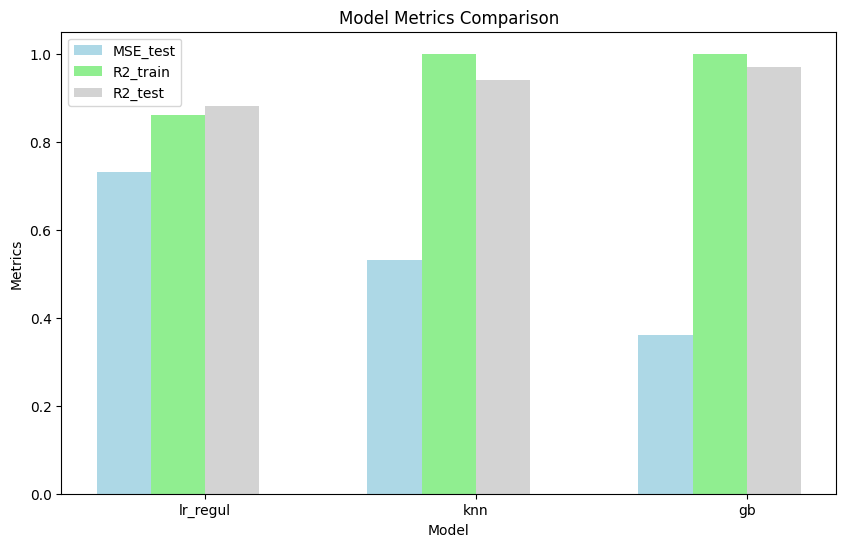

In [ ]:
# Создаем гистограмму
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = [i for i in range(len(METRICS))]

# Определяем метки и значения для баров
labels = list(METRICS.keys())
mse_test = [METRICS[label].get('MSE_test', None) for label in labels]
r2_train = [METRICS[label].get('R2_train', None) for label in labels]
r2_test = [METRICS[label].get('R2_test', None) for label in labels]

# Определяем ширину и цвет полос
width = 0.2
colors = ['lightblue', 'lightgreen', 'lightgray']

# Строим столбцы
ax.bar(x_pos, mse_test, width=width, color=colors[0], label='MSE_test')
ax.bar([x + width for x in x_pos], r2_train, width=width, color=colors[1], label='R2_train')
ax.bar([x + 2*width for x in x_pos], r2_test, width=width, color=colors[2], label='R2_test')

# Определяем оси
ax.set_xlabel('Model')
ax.set_ylabel('Metrics')
ax.set_title('Model Metrics Comparison')
ax.set_xticks([x + 1.5*width for x in x_pos])
ax.set_xticklabels(labels)

# Строим легенду для графика
ax.legend()

# Отображаем график
plt.show()

Как можно видеть из графика градиентный бустинг (`gb`) имеет лучшие метрики. Именно данный алгоритм следует использовать для решения задачи предсказания цены аренды квартиры.